In [1]:
import brainpy as bp
import brainpy.math as bm
import numpy as np
import matplotlib.pyplot as plt
import scipy

import sys
sys.path.append('..')
from cann import CANN1D

#set backend to cpu
bm.set_platform('cpu')
seed=0

/home/zilong/anaconda3/envs/hippocampalsequence/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1, simulate theta sweeps when varying m

mbar =  4.0


Predict 51407 steps: : 100%|██████████| 51407/51407 [00:00<00:00, 51640.11it/s]


sweep_mean =  0.07555684
mbar =  4.5


Predict 51407 steps: : 100%|██████████| 51407/51407 [00:00<00:00, 53401.70it/s]


sweep_mean =  0.087542996
mbar =  5.0


Predict 51407 steps: : 100%|██████████| 51407/51407 [00:00<00:00, 53185.69it/s]


sweep_mean =  0.11217836
mbar =  5.5


Predict 51407 steps: : 100%|██████████| 51407/51407 [00:00<00:00, 51612.98it/s]


sweep_mean =  0.1758341
mbar =  6.0


Predict 51407 steps: : 100%|██████████| 51407/51407 [00:00<00:00, 53046.91it/s]


sweep_mean =  0.18832408
mbar =  6.5


Predict 51407 steps: : 100%|██████████| 51407/51407 [00:00<00:00, 52911.01it/s]


sweep_mean =  0.2537957
mbar =  7.0


Predict 51407 steps: : 100%|██████████| 51407/51407 [00:00<00:00, 53409.68it/s]


sweep_mean =  0.2988759
mbar =  7.5


Predict 51407 steps: : 100%|██████████| 51407/51407 [00:00<00:00, 53138.58it/s]


sweep_mean =  0.32006356
mbar =  8.0


Predict 51407 steps: : 100%|██████████| 51407/51407 [00:00<00:00, 52808.55it/s]


sweep_mean =  0.5835181
mbar =  8.5


Predict 51407 steps: : 100%|██████████| 51407/51407 [00:00<00:00, 53054.92it/s]


sweep_mean =  0.9222296
mbar =  9.0


Predict 51407 steps: : 100%|██████████| 51407/51407 [00:00<00:00, 52637.89it/s]


sweep_mean =  0.87817377


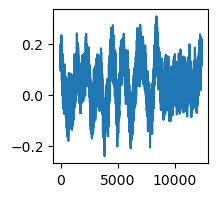

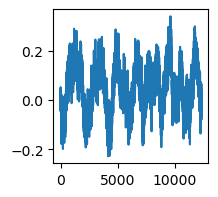

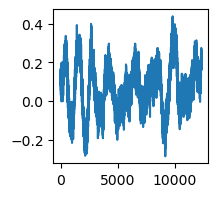

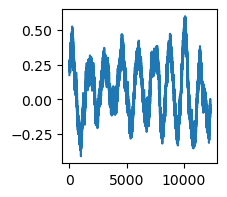

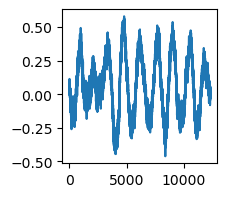

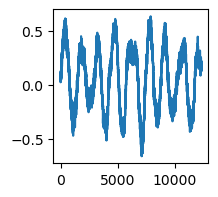

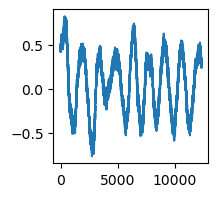

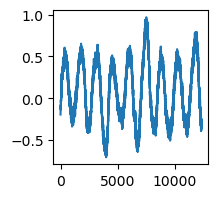

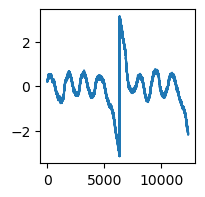

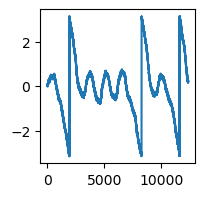

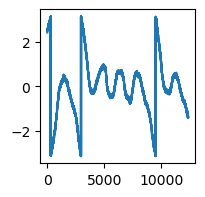

In [2]:
def get_sweep_amp(mbar):
    np.random.seed(seed)
    sweep_cann_1 = CANN1D(tau=1, tau_v=48., num=128, mbar=mbar, A=0.01, sigma_u=0.01, sigma_m=0.01)
    sweep_cann_1.reset_state()
    v_ext = sweep_cann_1.a / 144 * 0.55   #animal speed
    sweep_dur = 2.5*np.pi / v_ext              #duration of simulation
    dt = bm.get_dt()                     #simulation time step                         
    steps = int(sweep_dur / dt)                #steps of simulation

    position = np.zeros(steps)
    position[0] = -np.pi/3               #initial position
    #generate position array
    for i in range(steps)[1:]:
        position[i] = position[i - 1] + v_ext * dt
        if position[i] > np.pi:          #periodic boundary condition
            position[i] -= 2 * np.pi

    position = position.reshape((-1, 1)) #reshape to (steps, 1) array to fit the input shape

    noise = 0.001*np.random.randn(steps,sweep_cann_1.num) #add independent noise to the input with level 0.01

    #generate series of external input bump
    Iext = sweep_cann_1.get_stimulus_by_pos(position) + noise

    #simulate the network
    sweep_runner_1 = bp.DSRunner(sweep_cann_1,
                        inputs=('input', Iext, 'iter'),
                        monitors=['u', 'v', 'r','center','centerI'])
    sweep_runner_1.run(sweep_dur)
    
    #visualize bump sweeps for 1 second. Cut the middle 1 second to avoid transient at the boundary
    time = np.linspace(0, sweep_dur, steps)    #time array
    time_start = int(1.9*bm.pi / v_ext/ dt)
    time_end = int(2.9*bm.pi / v_ext/ dt)
    time_slice=time[time_start:time_end]
    #subtract time 0 from time_slice
    time_slice = time_slice - time_slice[0]

    ##Theta oscillations
    relative_pos = sweep_runner_1.mon.center[time_start:time_end] - sweep_runner_1.mon.centerI[time_start:time_end]
    relative_pos = bm.where(relative_pos > np.pi, relative_pos - 2*np.pi,  relative_pos)
    relative_pos = bm.where(relative_pos < -np.pi, relative_pos + 2*np.pi,  relative_pos)
    relative_pos = np.squeeze(relative_pos)

    #get the mean relative position after taking the abs
    mean_relative_pos = np.mean(np.abs(relative_pos))
    
    plt.figure(figsize=(2,2))
    plt.plot(relative_pos)
    
    return mean_relative_pos

#vary mbar from 4 to 9 with step 0.5
mbars = bm.linspace(4,9,11)

for mbar in mbars:
    print('mbar = ', mbar)

    sweep_mean = get_sweep_amp(mbar)
    
    print('sweep_mean = ', sweep_mean)

### 2, simulating replay when varying m

In [6]:
#log-log plot of the average step size against time bins
def get_diffusion_exponent(trajetory, plot=False, get_intercept=False): 
    
    #return plt
    all_timebins = np.arange(1,20,1)
    all_avg_steps = []
    for timeb in all_timebins:
        #trajectory is a 1D array with radians value, 
        #get the circular difference between each time bin
        all_steps = np.abs(np.diff(trajetory[::timeb])) 
        #all_steps = np.abs(trajetory[::timeb] - trajetory[timeb::timeb])
        #consider the periodic boundary condition if >pi or <-pi, then minus 2pi or plus 2pi
        all_steps = np.where(all_steps > np.pi, all_steps - 2*np.pi, all_steps)
        all_steps = np.where(all_steps < -np.pi, all_steps + 2*np.pi, all_steps)
        #get the average step size for each time bin
        avg_step = np.mean(all_steps)
        
        all_avg_steps.append(avg_step)
    #get the slope of the log-log plot
    slope, intercept = np.polyfit(np.log(all_timebins), np.log(all_avg_steps), 1)

    #print('The slope of the log-log plot is %.2f'%slope)
    if plot:
        fig, ax = plt.subplots(1,1, figsize=(3,3))
        #plot the log-log plot and add the slope as a lagend
        ax.plot(all_timebins, all_avg_steps, 'o', color='black')
        #add shadow plot of the std
        #ax.fill_between(all_timebins, np.array(all_avg_steps), np.array(all_avg_steps), color='black', alpha=0.2)
        ax.plot(all_timebins, np.exp(intercept)*all_timebins**slope, 'r-', label='slope = %.2f'%slope)  
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlabel('Time bins')
        ax.set_ylabel('Average step size')
        ax.legend()
        #set both ticks to [0,10]
        ax.set_xticks([1,10])
        ax.set_yticks([1,10])
        if get_intercept:
            return fig, ax, slope, intercept
        else:
            return fig, ax, slope
    else:
        if get_intercept:
            return slope, intercept
        else:
            return slope
        


In [7]:
def get_replay_exponent(mbar):
    replay_dur = 2000        #simulate 200 ms, roughly the length of a SWR
    init_dur = 50 #initial 10 ms to let the network settle

    #build and run the network
    #set default ramndom seed for reproducibility
    np.random.seed(seed)
    #set backend to cpu
    bm.set_platform('cpu')

    replay_cann_1 = CANN1D(tau=1., tau_v=48., num=128, mbar=mbar, A=0.01, sigma_m=0.01, sigma_u=0.01)
    replay_cann_1.reset_state()
    Iext, length = bp.inputs.section_input(
        values=[replay_cann_1.get_stimulus_by_pos(-3/4*np.pi), 0.], #initial position of the bump
        durations=[init_dur, replay_dur],
        return_length=True
    )
    noise = 0.02* np.random.randn(len(Iext), replay_cann_1.num) #add independent noise to the input with level 0.02
    Iext = Iext + noise
    Iext = bm.as_numpy(Iext)

    #run the network
    replay_runner_1 = bp.DSRunner(replay_cann_1,
                        inputs=('input', Iext, 'iter'),
                        monitors=['u', 'v', 'r','center','centerI'])

    replay_runner_1.run(length)
    
    
    bum_center = replay_runner_1.mon.center
    #squeeze the array
    bum_center = np.squeeze(bum_center)
        
    slope = get_diffusion_exponent(bum_center, plot=False)
    
    return slope, bum_center


#vary mbar from 4 to 9 with step 0.5
mbars = bm.linspace(0.1,2,11)

for mbar in mbars:
    slope, bum_center = get_replay_exponent(mbar)
    
    #print mbar and the slope in a line
    print('mbar = ', mbar, 'slope = ', slope)
    
    
    plt.figure(figsize=(2,2))
    plt.plot(bum_center)

Predict 20500 steps: :   0%|          | 0/20500 [00:00<?, ?it/s]

Predict 20500 steps: : 100%|██████████| 20500/20500 [00:00<00:00, 35726.12it/s]


ValueError: operands could not be broadcast together with shapes (20500,) (20499,) 

In [14]:
slope.shape

(2500, 1)